Enhanced Evaluation Metrics:
R2: 0.9486081370449679
Adjusted_R2: 0.8458244111349038
ExplainedVariance: 0.9571734475374732
RMSE: 0.6123724356957945
MAE: 0.5
MAPE: 32.73809523809524
MedianAE: 0.5
Residuals: [ 0.5 -0.5  0.  -1. ]


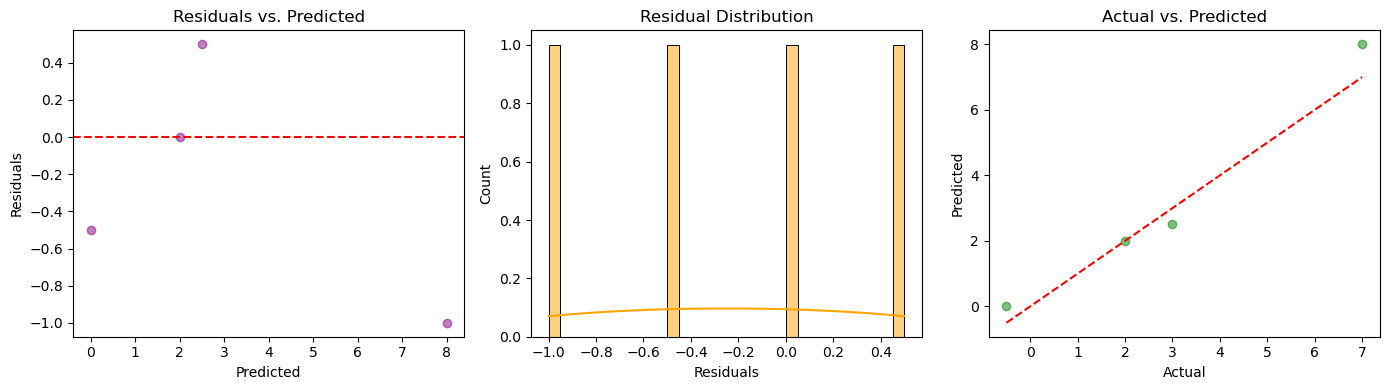

Cross-validation results:
{'R2': {'mean': 0.9891457682115246, 'std': 0.00309194057141985}, 'Adjusted_R2': {'mean': 0.9878687997658215, 'std': 0.003455698285704562}, 'ExplainedVariance': {'mean': 0.9895710580546071, 'std': 0.0033870053967096437}, 'RMSE': {'mean': 0.1001855453523266, 'std': 0.012601921670649338}, 'MAE': {'mean': 0.0841726863419136, 'std': 0.01285700489843192}, 'MAPE': {'mean': 42.49355859258567, 'std': 22.354714407543515}, 'MedianAE': {'mean': 0.07891624726693855, 'std': 0.01754937653219199}, 'Residuals': {'mean': 0.0011678227340963631, 'std': 0.10096825301746089}}
Logged parameters and metrics to dummy_model_log.json


In [1]:
#test these please I am not sure
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    mean_absolute_error, 
    median_absolute_error,
    explained_variance_score
)
from sklearn.model_selection import KFold

def evaluate_regression(y_true, y_pred, n_features=None):
    """
    Evaluates regression predictions by calculating multiple metrics.
    
    Parameters:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
        n_features (int, optional): Number of features used in the model.
            If provided, computes Adjusted R².
    
    Returns:
        dict: A dictionary with metrics:
            - R2: R-squared score.
            - Adjusted_R2: Adjusted R-squared (if n_features provided).
            - ExplainedVariance: Explained variance score.
            - RMSE: Root Mean Squared Error.
            - MAE: Mean Absolute Error.
            - MAPE: Mean Absolute Percentage Error (%).
            - MedianAE: Median Absolute Error.
            - Residuals: y_true - y_pred.
    """
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    median_ae = median_absolute_error(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    
    # Calculate MAPE (with safe division)
    y_true_safe = np.where(np.array(y_true)==0, 1, np.array(y_true))
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true_safe)) * 100
    
    residuals = np.array(y_true) - np.array(y_pred)
    
    adjusted_r2 = None
    n = len(y_true)
    if n_features is not None and n > n_features + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    
    metrics = {
        "R2": r2,
        "Adjusted_R2": adjusted_r2,
        "ExplainedVariance": evs,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "MedianAE": median_ae,
        "Residuals": residuals
    }
    return metrics

def plot_diagnostics(y_true, y_pred):
    """
    Generates diagnostic plots:
      - Residuals vs. Predicted values.
      - Histogram (with KDE) of residuals.
      - Scatter plot of Actual vs. Predicted values.
    """
    residuals = np.array(y_true) - np.array(y_pred)
    
    plt.figure(figsize=(14, 4))
    
    # Residuals vs. Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Predicted")
    
    # Histogram of Residuals
    plt.subplot(1, 3, 2)
    sns.histplot(residuals, kde=True, color='orange', bins=30)
    plt.xlabel("Residuals")
    plt.title("Residual Distribution")
    
    # Actual vs. Predicted
    plt.subplot(1, 3, 3)
    plt.scatter(y_true, y_pred, alpha=0.5, color='green')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs. Predicted")
    
    plt.tight_layout()
    plt.show()

def cross_val_evaluate(model, X, y, cv=5, n_features=None):
    """
    Performs k-fold cross-validation and computes evaluation metrics on each fold.
    
    Parameters:
        model: A scikit-learn-like estimator with fit/predict methods.
        X (DataFrame or array-like): Features.
        y (Series or array-like): Target values.
        cv (int): Number of folds for cross-validation.
        n_features (int, optional): Number of features for Adjusted R² computation.
    
    Returns:
        dict: Mean and standard deviation for each metric across folds.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    metrics_list = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = evaluate_regression(y_test, y_pred, n_features=n_features)
        metrics_list.append(metrics)
    
    summary = {}
    keys = metrics_list[0].keys()
    for key in keys:
        values = np.array([m[key] for m in metrics_list if m[key] is not None])
        summary[key] = {"mean": np.mean(values), "std": np.std(values)}
    return summary

def log_parameters(params, metrics, file_path="model_log.json"):
    """
    Logs model parameters and evaluation metrics to a JSON file.
    
    Parameters:
        params (dict): Model parameters/hyperparameters.
        metrics (dict): Evaluation metrics.
        file_path (str): Path to the log JSON file.
    """
    log_entry = {
        "params": params,
        "metrics": metrics
    }
    
    try:
        with open(file_path, "r") as f:
            log_data = json.load(f)
    except FileNotFoundError:
        log_data = []
    
    log_data.append(log_entry)
    
    with open(file_path, "w") as f:
        json.dump(log_data, f, indent=4)
    print(f"Logged parameters and metrics to {file_path}")

if __name__ == "__main__":
    # Sample true and predicted values for testing, DONT FORGET TO CHANGE THIS PLEASE LOOK HERE
    y_true = np.array([3, -0.5, 2, 7])
    y_pred = np.array([2.5, 0.0, 2, 8])
    test_metrics = evaluate_regression(y_true, y_pred, n_features=2)
    print("Enhanced Evaluation Metrics:")
    for key, value in test_metrics.items():
        if key != "Residuals":
            print(f"{key}: {value}")
    print("Residuals:", test_metrics["Residuals"])
    
    # Plot diagnostics
    plot_diagnostics(y_true, y_pred)
    
    # Dummy cross-validation example using a simple model (e.g., Linear Regression)
    from sklearn.linear_model import LinearRegression
    import pandas as pd
    # Create dummy dataset
    X_dummy = pd.DataFrame({
        'feature1': np.random.rand(100),
        'feature2': np.random.rand(100)
    })
    y_dummy = X_dummy['feature1'] * 3 + X_dummy['feature2'] * (-2) + np.random.randn(100)*0.1
    model = LinearRegression()
    cv_results = cross_val_evaluate(model, X_dummy, y_dummy, cv=5, n_features=2)
    print("Cross-validation results:")
    print(cv_results)
    
    # Dummy parameter logging
    dummy_params = {"model": "LinearRegression", "fit_intercept": True}
    dummy_metrics = cv_results
    log_parameters(dummy_params, dummy_metrics, file_path="dummy_model_log.json")

